In [1]:
import numpy as np
import sympy as sp
import tensorflow as tf
import matplotlib.pyplot as plt

from environments.buchberger import BinomialBuchbergerEnv, LeadMonomialWrapper
from agents.buchberger import RandomAgent, DegreeAgent
from agents.networks import ParallelMultilayerPerceptron

# Agent

In [2]:
def discounted_rewards(rewards, gamma):
    out = np.empty(len(rewards))
    cumulative_reward = 0
    for i in reversed(range(len(rewards))):
        cumulative_reward = rewards[i] + gamma * cumulative_reward
        out[i] = cumulative_reward
    return list(out)


class PGAgent:
    """A policy gradient agent."""

    def __init__(self, network, learning_rate=0.00025, gamma=0.99):
        self.model = self._buildModel(network, learning_rate)
        self.gamma = gamma

    def act(self, state):
        """Choose an action (row) for the given state."""
        probs = self.model.predict(np.expand_dims(state, axis=0))[0]
        return np.random.choice(len(probs), p=probs)

    def train(self, env, episodes):
        """Train the agent using policy gradients."""
        total_states = []
        total_actions = []
        total_rewards = []

        # generate rollouts and discounted rewards
        for _ in range(episodes):
            state = env.reset()
            done = False
            states = []
            actions = []
            rewards = []
            while not done:
                action = self.act(state)
                next_state, reward, done, _ = env.step(action)
                states += [state]
                actions += [action]
                rewards += [reward]
                state = next_state
            rewards = discounted_rewards(rewards, self.gamma)

            total_states += states
            total_actions += actions
            total_rewards += rewards

        for i in range(len(total_states)):
            state = np.expand_dims(total_states[i], axis=0)
            advantage = np.zeros((1, state.shape[1]))
            advantage[0, total_actions[i]] = total_rewards[i]
            
            self.model.fit(state, advantage, verbose=0)
            
    def test(self, env, episodes):
        """Test the agent for given episodes on given environment."""
        rewards = np.zeros(episodes)
        for i in range(episodes):
            state = env.reset()
            done = False
            while not done:
                action = self.act(state)
                next_state, reward, done, _ = env.step(action)
                rewards[i] += reward
                state = next_state
        return rewards

    def save(self, name):
        self.model.save_weights(name)

    def load(self, name):
        self.model.load_weights(name)

    def _buildModel(self, network, learning_rate):
        model = tf.keras.models.clone_model(network)
        loss = 'categorical_crossentropy'
        optimizer = tf.keras.optimizers.Adam(learning_rate)
        model.compile(loss=loss, optimizer=optimizer)
        return model

# Testing

In [3]:
degree = 2
size = 5
env = BinomialBuchbergerEnv(degree, size)
network = ParallelMultilayerPerceptron(6, [12])

In [7]:
agent = RandomAgent()

episodes = 10000
random_rewards = np.zeros(episodes)

for i in range(episodes):
    state = env.reset()
    done = False
    while not done:
        action = agent.act(state)
        state, reward, done, _ = env.step(action)
        random_rewards[i] += reward
        
np.mean(random_rewards)

-33.2396

In [8]:
agent = DegreeAgent()

episodes = 10000
degree_rewards = np.zeros(episodes)

for i in range(episodes):
    state = env.reset()
    done = False
    while not done:
        action = agent.act(state)
        state, reward, done, _ = env.step(action)
        degree_rewards[i] += reward
        
np.mean(degree_rewards)

-21.5776

In [ ]:
env = LeadMonomialWrapper(env)
agent = PGAgent(network)

epochs = 10000
rewards = []
for i in range(epochs):
    agent.train(env, 100)
    r = np.mean(agent.test(env, 100))
    rewards.append(r)
    print("\rEpoch {} - reward: {}".format(i, r), end="")

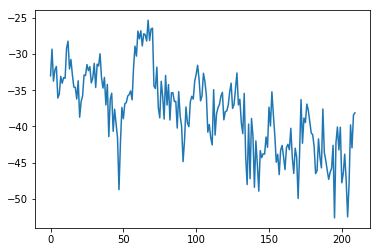

In [8]:
plt.plot(rewards)